# Overview

Accelerometer data can be pretty fun and unique to work with. Firstly, it is important to understand that this data is a time series. We are looking for Turning, StartHesitation, and Walking events in these time series. In my notebook, I demonstrate an example of each of these types of events in a signal.

I also take a look at a few useful feature engineering ideas. One idea to to search for relative extrema (maximums and minimums). This could be useful as a feature or useful in detecting outliers. This information could then be used to help us determine the time of the freezing episode.

Another piece of information that could be useful is the change in signal from one time step to the next. This information could be useful in determining a sudden and quick change in movement.

I believe an effective approach for this competition could be the following:
- take a window of values around a given time step
- feature engineer those values
- feed the values and the features the the sub signal to a model
- post process the results with interpolation and other techniques

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
events = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/events.csv")

turn_id = list(events[events.Type=="Turn"].Id)[0]
hes_id = list(events[events.Type=="StartHesitation"].Id)[0]
walk_id = list(events[events.Type=="Walking"].Id)[0]

turn_df = pd.read_csv(f"/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/{turn_id}.csv")
hes_df = pd.read_csv(f"/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/{hes_id}.csv")
walk_df = pd.read_csv(f"/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/{walk_id}.csv")
defog_df = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/02ea782681.csv")

# Plotting Full Time Series

In [3]:
def plot_xyz(V, ML, AP):
    plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,10))

    plt.subplot(3, 1, 1)
    plt.plot(V, color='#69cf83', label='V')
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(ML, color='#d6b258', label='ML')
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(AP, color='#96bcfa', label='AP')
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.legend()

    plt.show()

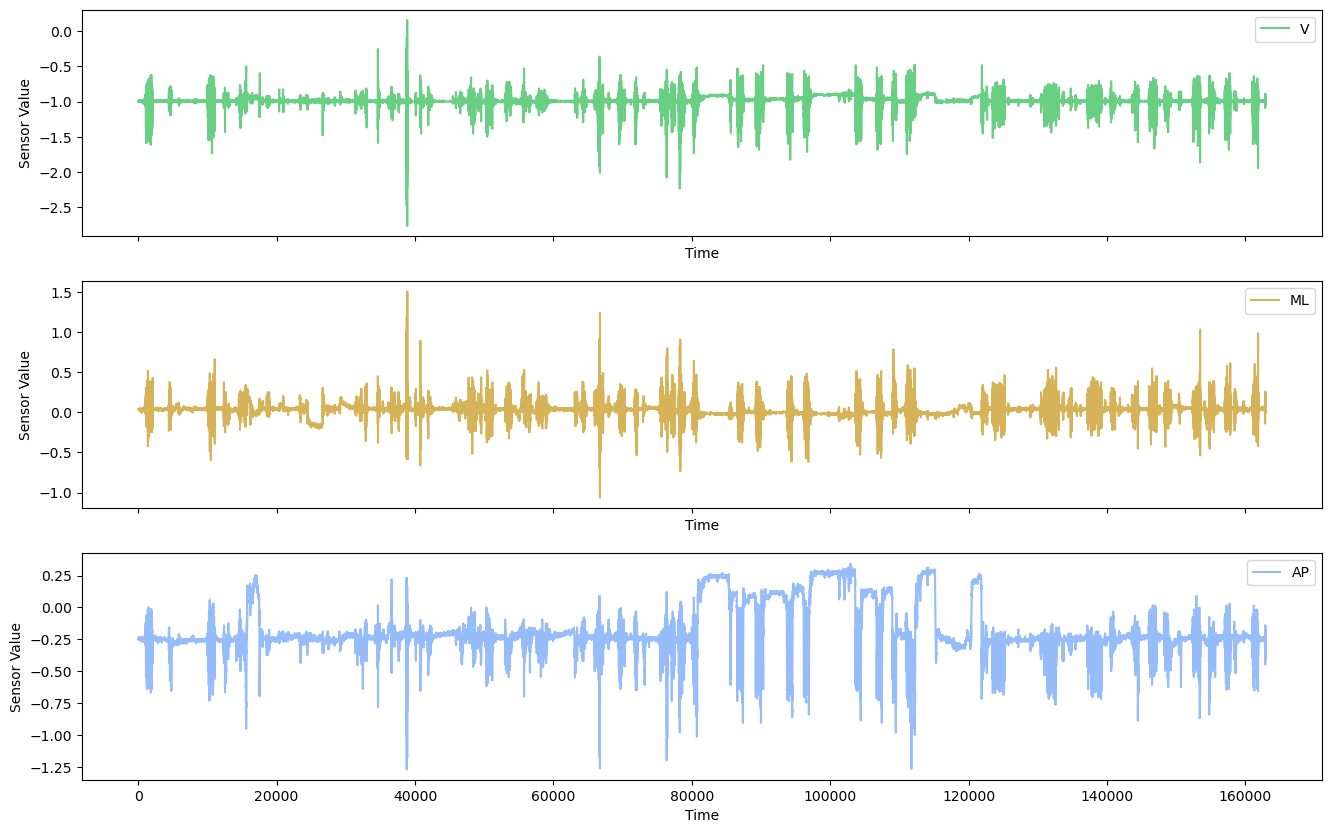

In [4]:
plot_xyz(defog_df.AccV, defog_df.AccML, defog_df.AccAP)

# Plotting Events

The shaded section of eah graph shows the time the vent happends.

In [5]:
def to_ranges(l_set):
    rb_set = sorted(l_set - {i +1 for i in l_set})
    re_set = sorted(l_set - {i -1 for i in l_set})
    return [(rb_set[i], re_set[i]+1) for i in range(len(rb_set))]

def plot_event(V, ML, AP, start, stop, padding):
    plt.plot(V[start-padding:stop+padding], color='#69cf83', label='V')
    plt.plot(ML[start-padding:stop+padding], color='#d6b258', label='ML')
    plt.plot(AP[start-padding:stop+padding], color='#96bcfa', label='AP')
    plt.axvspan(start, stop, color='brown', alpha=0.2)
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

### Turn Event Example

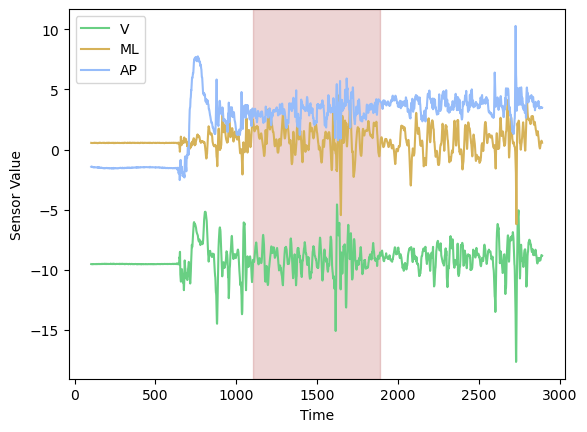

In [6]:
vals = list(turn_df[turn_df.Turn!=0].Time)
rng = to_ranges(set(vals))[0]
plot_event(turn_df.AccV, turn_df.AccML, turn_df.AccAP, rng[0], rng[1], 1000)

### Start Hesitation Event Example

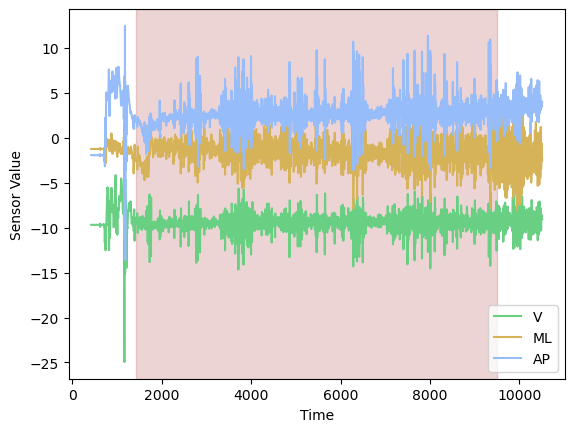

In [7]:
vals = list(hes_df[hes_df.StartHesitation!=0].Time)
rng = to_ranges(set(vals))[0]
plot_event(hes_df.AccV, hes_df.AccML, hes_df.AccAP, rng[0], rng[1], 1000)

### Walking Event Example

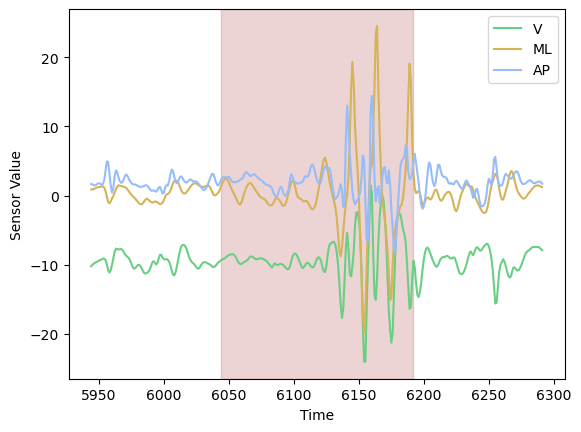

In [8]:
vals = list(walk_df[walk_df.Walking!=0].Time)
rng = to_ranges(set(vals))[0]
plot_event(walk_df.AccV, walk_df.AccML, walk_df.AccAP, rng[0], rng[1], 100)

# Finding Relative Extrema

The example event I am using is a walking event. The red dots show the relative maximums and minimums.

[]

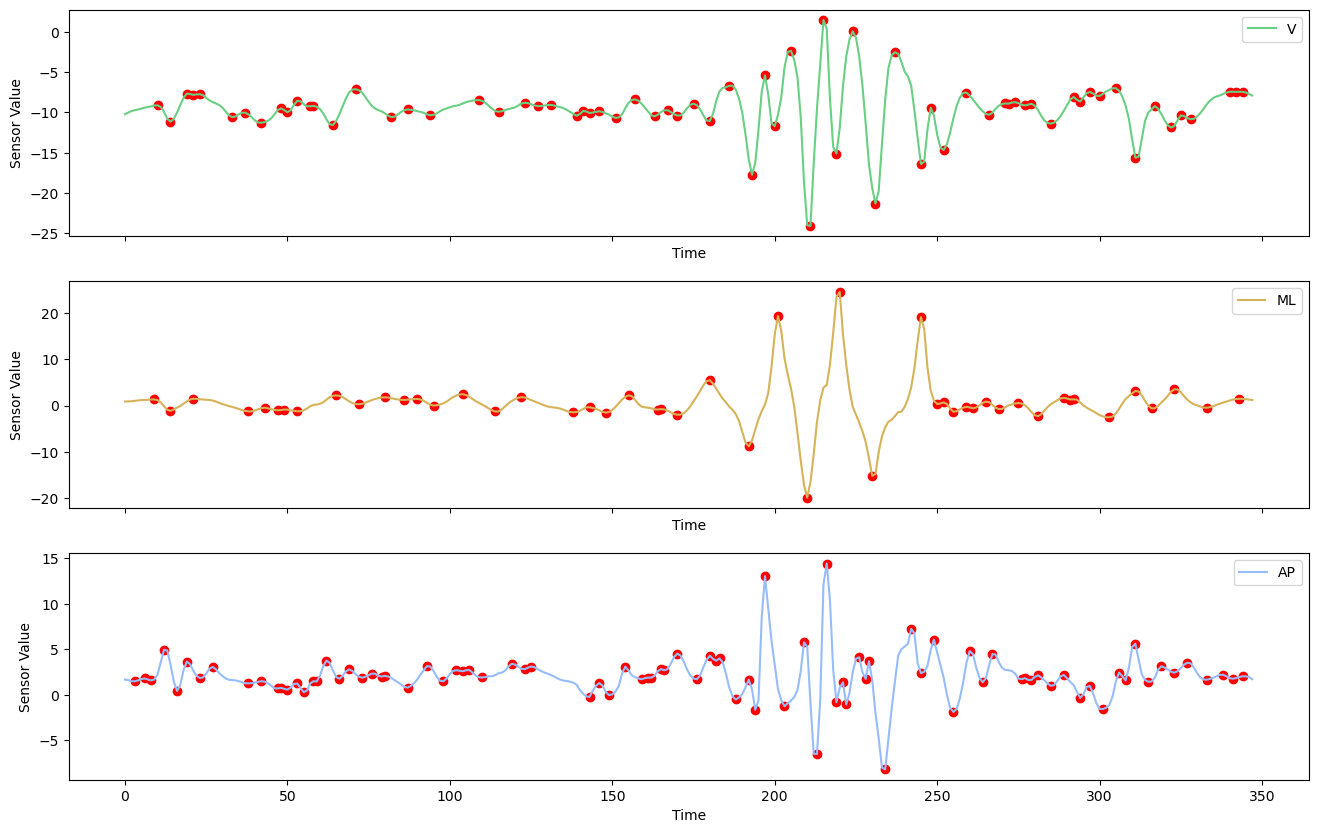

In [9]:
vals = list(walk_df[walk_df.Walking!=0].Time)
rng = to_ranges(set(vals))[0]
V = walk_df.AccV[rng[0]-100:rng[1]+100].reset_index(drop=True)
ML = walk_df.AccML[rng[0]-100:rng[1]+100].reset_index(drop=True)
AP = walk_df.AccAP[rng[0]-100:rng[1]+100].reset_index(drop=True)

plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,10))

plt.subplot(3, 1, 1)
peaks = find_peaks(V)
valleys = find_peaks(-V)
plt.plot(V, color='#69cf83', label='V')
plt.scatter(peaks[0], [V[p] for p in peaks[0]], color='r')
plt.scatter(valleys[0], [V[p] for p in valleys[0]], color='r')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()

plt.subplot(3, 1, 2)
peaks = find_peaks(ML)
valleys = find_peaks(-ML)
plt.plot(ML, color='#d6b258', label='ML')
plt.scatter(peaks[0], [ML[p] for p in peaks[0]], color='r')
plt.scatter(valleys[0], [ML[p] for p in valleys[0]], color='r')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()

plt.subplot(3, 1, 3)
peaks = find_peaks(AP)
valleys = find_peaks(-AP)
plt.plot(AP, color='#96bcfa', label='AP')
plt.scatter(peaks[0], [AP[p] for p in peaks[0]], color='r')
plt.scatter(valleys[0], [AP[p] for p in valleys[0]], color='r')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
    
plt.plot()

# Plotting the Delta

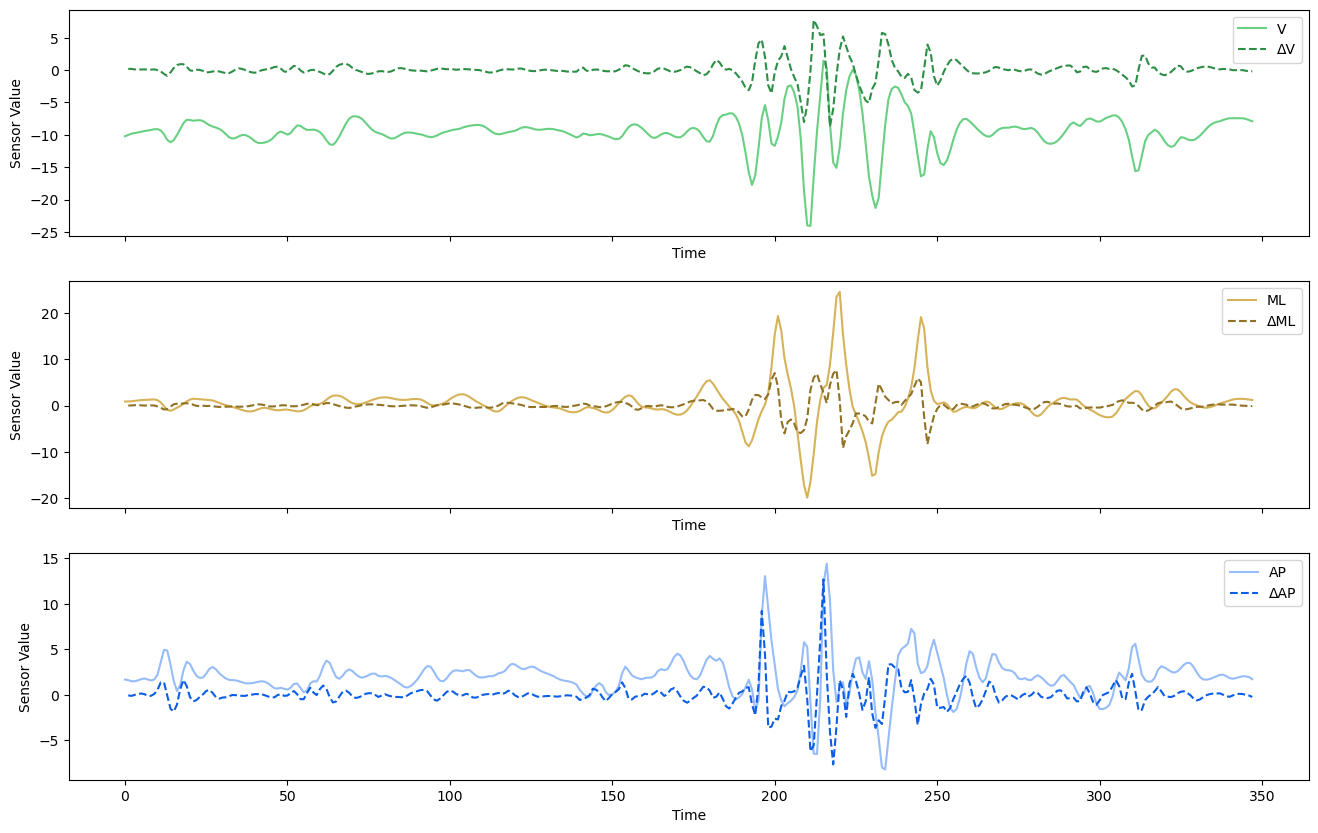

In [10]:
plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,10))

plt.subplot(3, 1, 1)
plt.plot(V, color='#69cf83', label='V')
plt.plot(V.diff(), color='#2d8e46', linestyle='dashed', label='ΔV')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(ML, color='#d6b258', label='ML')
plt.plot(ML.diff(), color='#917224', linestyle='dashed', label='ΔML')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(AP, color='#96bcfa', label='AP')
plt.plot(AP.diff(), color='#0b5ee5', linestyle='dashed', label='ΔAP')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.show()

# Plotting the Trend

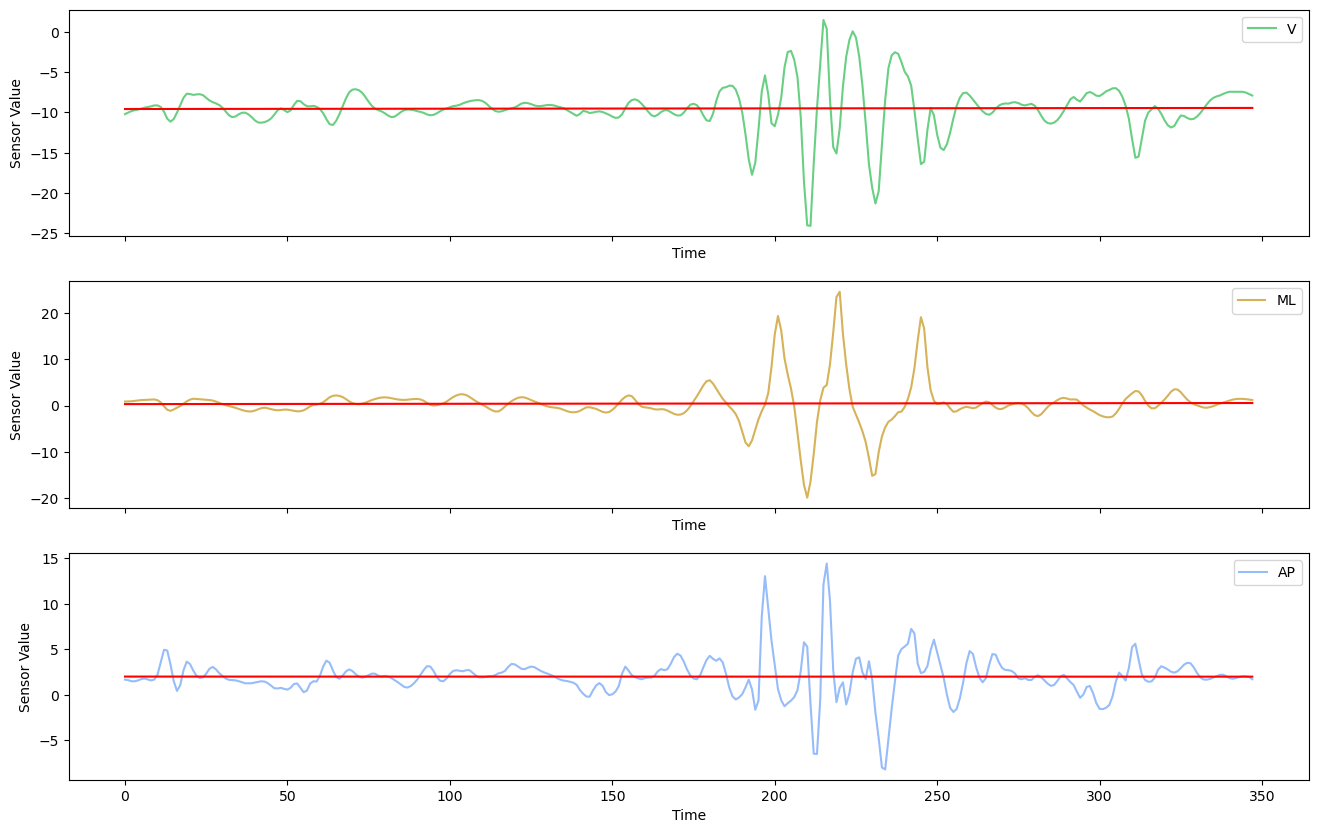

In [11]:
plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,10))

plt.subplot(3, 1, 1)
plt.plot(V, color='#69cf83', label='V')
a, b = np.polyfit(V.index, V, 1)
plt.plot(V.index, a*V.index+b, color='red')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(ML, color='#d6b258', label='ML')
a, b = np.polyfit(ML.index, ML, 1)
plt.plot(ML.index, a*ML.index+b, color='red')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(AP, color='#96bcfa', label='AP')
a, b = np.polyfit(AP.index, AP, 1)
plt.plot(AP.index, a*AP.index+b, color='red')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.show()